In [16]:
import os
import csv
from typing import Any, Tuple, List

import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

In [17]:
class MyDataset(Dataset):
    def __init__(self, path_to_annot_file: str, transform: Any=None, train: bool=False, test: bool=False, valid: bool=False) -> None:
        self.path_to_annot_file = path_to_annot_file
        self.data = self.get_data(path_to_annot_file, train, test, valid)
        self.transform = transform

    def get_data(self, path_to_annot_file: str, train: bool=False, test: bool=False, valid: bool=False) -> pd.DataFrame:
        data = pd.read_csv(path_to_annot_file, usecols = (0, 2), names = ('path_to_image', 'label'))
        data = data.sample(frac=1).reset_index(drop=True)
        data['label'] = data['label'].apply(lambda label: 0 if label == 'rose' else 1)
        train_size = int(0.8 * data.shape[0])
        test_valid_size = int(0.1 * data.shape[0])
        if train == True:
            data = data.iloc[:train_size, :]
        elif test == True:
            data = data.iloc[train_size:train_size + test_valid_size, :]
        elif valid == True:
            data = data.iloc[train_size + test_valid_size:, :]
        return data

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
        path_to_image = self.data.iloc[index, 0]
        image = cv2.cvtColor(cv2.imread(path_to_image), cv2.COLOR_BGR2RGB)
        label = self.data.iloc[index, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

In [18]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Resize((224, 224)),
                                                    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                                    torchvision.transforms.RandomHorizontalFlip(p=0.5)])

In [19]:
train_data = MyDataset(path_to_annot_file='Annotasion.csv', transform=transforms, train = True)
test_data = MyDataset(path_to_annot_file='Annotasion.csv', transform=transforms, test = True)
valid_data = MyDataset(path_to_annot_file='Annotasion.csv', transform=transforms, valid = True)
len(train_data), len(test_data), len(valid_data)

(1600, 200, 201)

In [20]:
train_data.data['label'].value_counts()

label
1    801
0    799
Name: count, dtype: int64

In [21]:
test_data.data['label'].value_counts()

label
0    108
1     92
Name: count, dtype: int64

In [15]:
valid_data.data['label'].value_counts()

label
1    105
0     96
Name: count, dtype: int64

In [ ]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3,
                                stride = 2)
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,
                                stride = 2)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.max_pool = nn.MaxPool2d(2)

        self.fully_connect1 = nn.Linear(5408, 10)
        self.fully_connect2 = nn.Linear(10, 1)

    def forward(self, x:torch.tensor) -> torch.tensor:
        output = self.relu(self.conv_1(x))
        output = self.max_pool(output)
        output = self.relu(self.conv_2(output))
        output = self.max_pool(output)
        output = torch.nn.Flatten()(output)
        output = self.relu(self.fully_connect1(output))
        output = torch.nn.Sigmoid()(self.fully_connect2(output))
        return output

In [22]:
train_loader = DataLoader(dataset=train_data, batch_size=4, shuffle = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


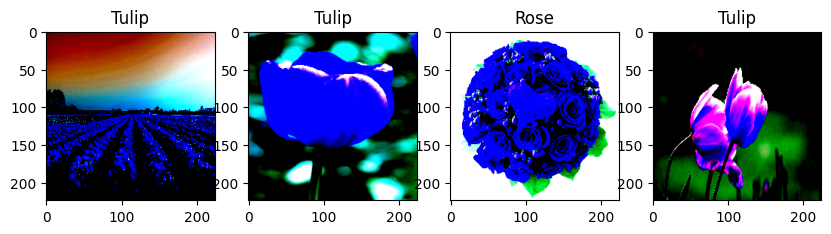

In [26]:
plt.figure(figsize = (10, 5))

for i, sample_batched in enumerate(train_loader):
    if i == 1:
        break
    for j in range(4):
        plt.subplot(1, 4, j + 1)
        plt.title('Rose' if sample_batched[1][j] == 0 else 'Tulip')
        plt.imshow(sample_batched[0][j].permute(1, 2, 0).numpy()[:, :, ::-1])